Patrick BROCKMANN - LSCE (Climate and Environment Sciences Laboratory)<br>
<img align="left" width="40%" src="http://www.lsce.ipsl.fr/Css/img/banniere_LSCE_75.png" ><br><br>
<hr>

Last update: 2016/01/20

This notebook tests cartopy and matplotlib to produce maps from OPA or NEMO configuration.

Cartopy runs more correctly that matplotlib/Basemap with curvilinear grids such as OPA/NEMO configuration.<br>
But I have noticed some annoying problems:
 * There are overlaps when I request a ccrs.Robinson(central_longitude=180) for ORCA2.0
     <img src="Robinson_ORCA2.0_lon180.png"  width="300px">
 * There are overlaps when I request a ccrs.Robinson(central_longitude=0) for ORCA0.25 but it works for central_longitude=180 (despite some warnings)
<pre>
 Self-intersection at or near point -8522424.5877420027 8620437.3051761631
WARNING:shapely.geos:Self-intersection at or near point -8522424.5877420027 8620437.3051761631
</pre>
    <img src="Robinson_ORCA0.25_lon0.png"  width="300px">
 * It is impossible to get correct filled contours (try by replacing pcolormesh by pcontourf)
     <img src="Robinson_ORCA2.0_contourf.png"  width="300px">
 * With cartopy, there is no boudinglat option for ccrs.NorthPolarStereo

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid, addcyclic
import numpy as np
import netCDF4
%matplotlib inline
print matplotlib.__version__

1.5.1


In [2]:
import cartopy
import cartopy.crs as ccrs
print cartopy.__version__

0.13.1


## ORCA2.0, a coarse OPA/NEMO configuration with curvilinear grid

### Read file

In [3]:
f=netCDF4.Dataset("http://dods.ipsl.jussieu.fr/cgi-bin/nph-dods/brocksce/matplotlib/ORCA2.0_ex1.nc")
lats = f.variables['lat'][:]
lons = f.variables['lon'][:]
var = f.variables['tos'][0][:]

print "Shape: (%4d, %4d)   Min=%.3g Max=%.3g Mean=%.3g Std=%.3g" \
                %(var.shape[0], var.shape[1], var.min(), var.max(), var.mean(), var.std())

Shape: ( 149,  182)   Min=271 Max=306 Mean=287 Std=11.4


### Test with cartopy

/opt/anaconda/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


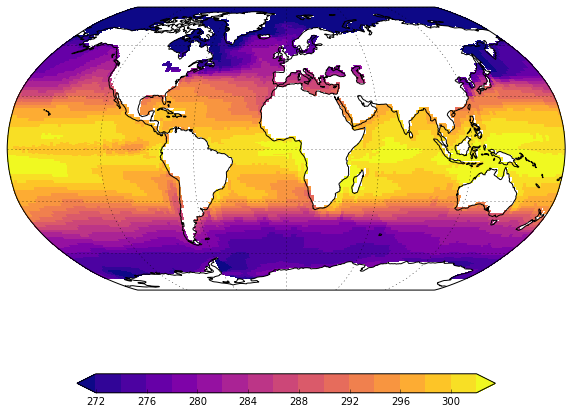

In [4]:
plt.figure(figsize=(10,10))

levels = np.arange(272,304,2)
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0, 1, len(levels)+1))
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

ax = plt.axes(projection=ccrs.Robinson(central_longitude=0))
#ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))                            # does not work
#ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=60))     # works

ax.set_global()

map = ax.pcolormesh(lons, lats, var,                           # contourf does not work
                transform=ccrs.PlateCarree(),
                cmap=cmap, norm=norm)

plt.colorbar(map, orientation='horizontal', shrink=0.75)
            
ax.gridlines()
ax.coastlines()

#plt.savefig("Robinson_ORCA2.0_lon180.png")
plt.show()

### Test with matplotlib/Basemap

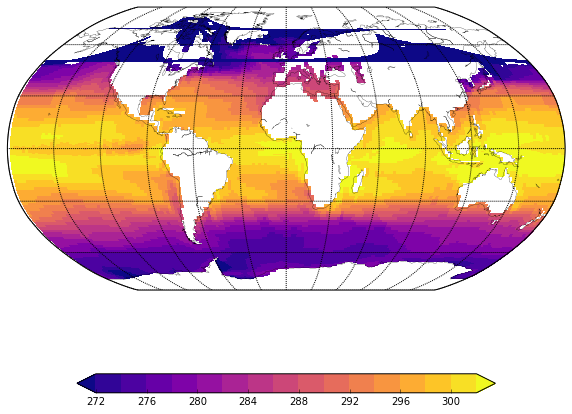

In [5]:
plt.figure(figsize=(10,10))

map = Basemap(projection='robin', lat_0=0, lon_0=0, resolution='c')            # does not work
#map = Basemap(projection='ortho', lat_0=60, lon_0=0, resolution='c')          # does not work
#map = Basemap(projection='npstere', lon_0=0, boundinglat=30, resolution='c')  # works
map.drawcoastlines(linewidth=0.25)
map.drawmeridians(np.arange(0, 360, 30))
map.drawparallels(np.arange(-90, 90, 30))

levels = np.arange(272,304,2)
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0, 1, len(levels)+1))
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

map.pcolormesh(lons, lats, var, cmap=cmap, norm=norm, latlon=True)

plt.colorbar(orientation='horizontal', shrink=0.75)

## ORCA0.25, a fine OPA/NEMO configuration with curvilinear grid

### Read file

In [7]:
f=netCDF4.Dataset("http://dods.ipsl.jussieu.fr/cgi-bin/nph-dods/brocksce/matplotlib/ORCA0.25_ex1.nc")
lons = f.variables['NAV_LON'][:]
lats = f.variables['NAV_LAT'][:]
var = f.variables['VAR'][0][:]*1E9

print "Shape: (%4d, %4d)   Min=%.3g Max=%.3g Mean=%.3g Std=%.3g" \
                %(var.shape[0], var.shape[1], var.min(), var.max(), var.mean(), var.std())

subsampling = 1               # tested with 1, 2, 4
lons = lons[::subsampling,::subsampling]
lats = lats[::subsampling,::subsampling]
var = var[::subsampling,::subsampling]

print "Shape: (%4d, %4d)   Min=%.3g Max=%.3g Mean=%.3g Std=%.3g" \
               %(var.shape[0], var.shape[1], var.min(), var.max(), var.mean(), var.std())

Shape: (1021, 1442)   Min=0.583 Max=386 Mean=14.6 Std=7.97
Shape: (1021, 1442)   Min=0.583 Max=386 Mean=14.6 Std=7.97


### Test with cartopy

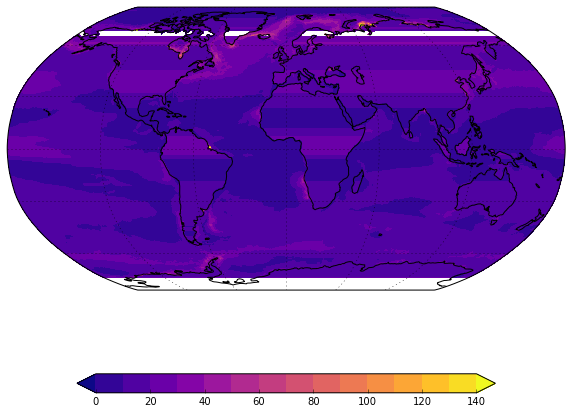

In [12]:
plt.figure(figsize=(10,10))

levels = np.arange(0,150,10)
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0, 1, len(levels)+1))
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

ax = plt.axes(projection=ccrs.Robinson(central_longitude=0))              # works
#ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))                # does not work
#ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=60))  # works
#ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))        # works but not boundinglat option 

ax.set_global()

map = ax.pcolormesh(lons, lats, var,
                transform=ccrs.PlateCarree(),    
                cmap=cmap, norm=norm)

plt.colorbar(map, orientation='horizontal', shrink=0.75)
            
ax.gridlines()
ax.coastlines()

#plt.savefig("Robinson_ORCA0.25_lon0.png")
plt.show()

### Test with matplotlib/Basemap

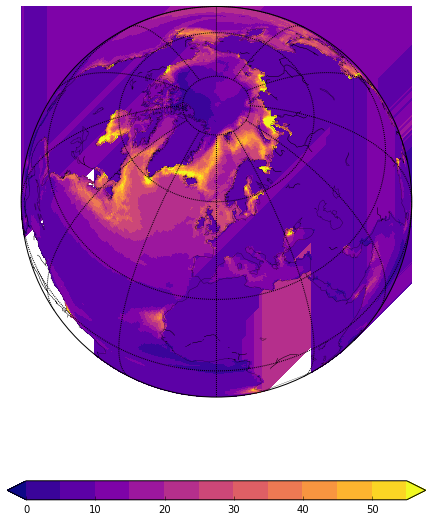

In [27]:
plt.figure(figsize=(10,10))

#map = Basemap(projection='robin', lat_0=0, lon_0=100, resolution='c')
map = Basemap(projection='ortho', lat_0=60, lon_0=0, resolution='c')
#map = Basemap(projection='npstere', lon_0=0, boundinglat=30, resolution='c')

map.drawcoastlines(linewidth=0.25)
map.drawmeridians(np.arange(0, 360, 30))
map.drawparallels(np.arange(-90, 90, 30))

cmap = plt.get_cmap('plasma')

levels = np.arange(0,60,5)
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0, 1, len(levels)+1))
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

map.pcolormesh(lons, lats, var, cmap=cmap, norm=norm, latlon=True)

plt.colorbar(orientation='horizontal', shrink=0.75)
plt.show()